1. Install and Import Dependencies


In [62]:
%pip install easyocr
%pip install imutils
%pip install opencv-python
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [63]:

import cv2 
from matplotlib import pyplot as plt
import numpy as np
import easyocr
import imutils

2. Read the image. apply filters like grayscale and blur.

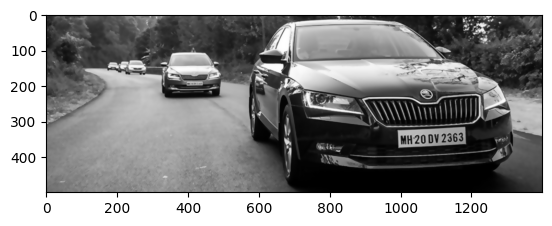

In [87]:
img = cv2.imread('image6.jpg') #read image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert image to gray
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
plt.imshow(cv2.cvtColor(bfilter, cv2.COLOR_BGR2RGB)) #show processed image

## 3. Find edges for localization

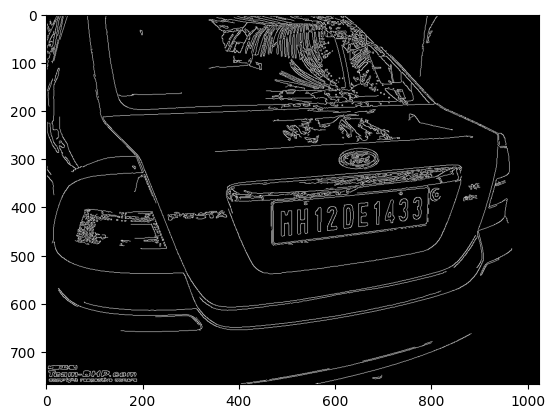

In [76]:
edged = cv2.Canny(bfilter, 30, 200) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

## 4. Find contours and apply mark to separate out actual number plate.

In [77]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) #Find contours 
contours = imutils.grab_contours(keypoints) #Grab contours 
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10] #Sort contours

In [78]:
#Loop over our contours to find the best possible approximate contour of our document
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [79]:
print("Location: ", location)

Location:  [[[794 363]]

 [[475 391]]

 [[473 475]]

 [[787 436]]]


In [80]:
mask = np.zeros(gray.shape, np.uint8) #create blank image with same dimensions as the original image
new_image = cv2.drawContours(mask, [location], 0,255, -1) #Draw contours on the mask image
new_image = cv2.bitwise_and(img, img, mask=mask) #Take bitwise AND between the original image and mask image

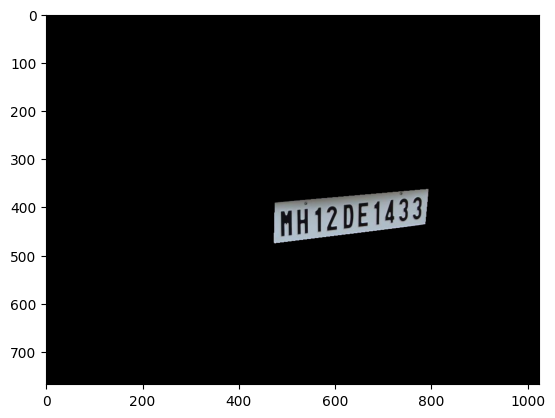

In [81]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)) #show the final image

In [82]:
(x,y) = np.where(mask==255) #Find the co-ordinates of the four corners of the document
(x1, y1) = (np.min(x), np.min(y)) #Find the top left corner
(x2, y2) = (np.max(x), np.max(y)) #Find the bottom right corner
cropped_image = gray[x1:x2+1, y1:y2+1] #Crop the image using the co-ordinates

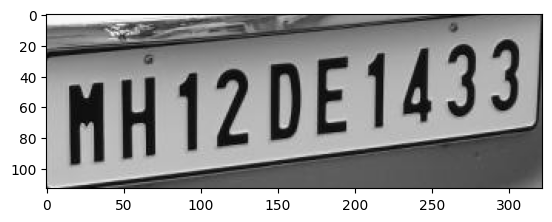

In [83]:
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)) #show the cropped image


## 5. Extract text from the number plate using OCR.

In [86]:
reader = easyocr.Reader(['en']) #create an easyocr reader object with english as the language
result = reader.readtext(cropped_image) #read text from the cropped image
result

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


[([[0, 0], [322, 0], [322, 112], [0, 112]], 'MHI2DE1423', 0.5609328907270911)]

## 6. Display the final output.

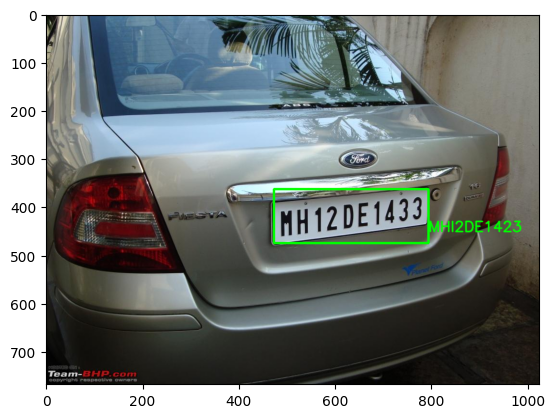

In [85]:
text = result[0][-2] #Extract the text from the result
font = cv2.FONT_HERSHEY_SIMPLEX #Font style
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA) #put the text on the image
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3) #Draw a rectangle around the text
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB)) #show the final image with text